**Predicting Presence of Diabetes with Age, BMI, and Blood Sugar Level**

**Introduction:**


Diabetes is a chronic disease that affects the body's ability to turn food into energy. Normally after consumption, glucose is released into the bloodstream causing the pancreas to release insulin. This provides a signal so that our cells can utilize the newly acquired blood sugar for energy. Diabetics, however, are unable to produce insulin or cannot utilize it effectively, leading to major health problems. Unfortunately, many people suffer from this health problem.

This project aims to answer the question: can diabetes in an individual be predicted accurately using their age, BMI, and blood glucose level?

The diabetes prediction data set contains medical information about patients' diabetes status (positive or negative) and other pertinent health information. There are 9 columns (containing categorical and numerical data): age, gender, BMI, hypertension, heart disease, smoking history, HbA1c level, blood glucose level, and diabetes status. In total, there are 100,000 participants and thus 100,000 rows available. 

**Methods & Results**

In [1]:
#loading packages
library(tidyverse)
library(tidymodels)
library(dplyr)
library(themis)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In this code, we start by setting the random seed to ensure that our analysis is reproducible. We then load the dataset directly from an online source. Given that our analysis involves categorization, it's crucial to convert the 'diabetes' variable into a factor type. This variable originally contains the values 0 and 1, which we change to 'non-diabetic' and 'diabetic' respectively for better readability.

After preparing the data, we split it into two subsets: 75% of the data is used for training our model, and the remaining 25% is used to test the model's prediction accuracy.

In [3]:
#set seed, loading dataset, and splitting into train and test sets

set.seed(1)

url <- "https://raw.githubusercontent.com/danialtaj0/Dataset/main/diabetes_prediction_dataset.csv"
diabetes_data <- read_csv(url) |>
                 mutate(diabetes = as_factor(diabetes)) |> 
                mutate(diabetes = fct_recode(diabetes, "non-diabetic" = "0", "diabetic" = "1")) |>
                rep_sample_n(10000)
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = diabetes)
diabetes_train <- training(diabetes_split) 
diabetes_test <- testing(diabetes_split)
head(diabetes_train)

ERROR: Error in rep_sample_n(mutate(mutate(read_csv(url), diabetes = as_factor(diabetes)), : could not find function "rep_sample_n"


In this section of the code, we analyze the distribution of our dataset's target variable to gain insights into class balance. Additionally, we select predictor variables based on specific criteria [mentioned here!](#predictor_explanation).

We then examine the dataset for any missing values, which is crucial for ensuring accurate calculations in subsequent analyses. The last part of the code focuses on visualizing missing data and computing the mean values of the selected predictors. For more detailed information on the summary table, click here for the summary table explanati.[Click here for explanation](#summary_table)e)

In [3]:
class_distribution <- diabetes_train |>
  group_by(diabetes) |>
  summarise(Count = n())

class_distribution

predictor_means <- diabetes_train |>
  summarise(
    mean_bmi = mean(bmi, na.rm = TRUE),
    mean_age = mean(age, na.rm = TRUE),
    mean_blood_glucose_level = mean(blood_glucose_level, na.rm = TRUE)
  )

predictor_means

# Filtering rows where there is missing data in any of the specified columns
rows_with_missing_data <- diabetes_train |>
  filter(is.na(bmi) | is.na(age) | is.na(blood_glucose_level) | is.na(diabetes))


print(rows_with_missing_data)

# Count the number of rows with missing data
num_rows_with_missing_data <- nrow(rows_with_missing_data)

# Print the count
missing_data <- tibble(n_rows_missing_data = num_rows_with_missing_data)
missing_data

diabetes,Count
<fct>,<int>
non-diabetic,6866
diabetic,634


replicate,mean_bmi,mean_age,mean_blood_glucose_level
<int>,<dbl>,<dbl>,<dbl>
1,27.27445,41.75922,138.3543


# A tibble: 0 × 10
# Groups:   replicate [0]
# ℹ 10 variables: replicate <int>, gender <chr>, age <dbl>, hypertension <dbl>,
#   heart_disease <dbl>, smoking_history <chr>, bmi <dbl>, HbA1c_level <dbl>,
#   blood_glucose_level <dbl>, diabetes <fct>


n_rows_missing_data
<int>
0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


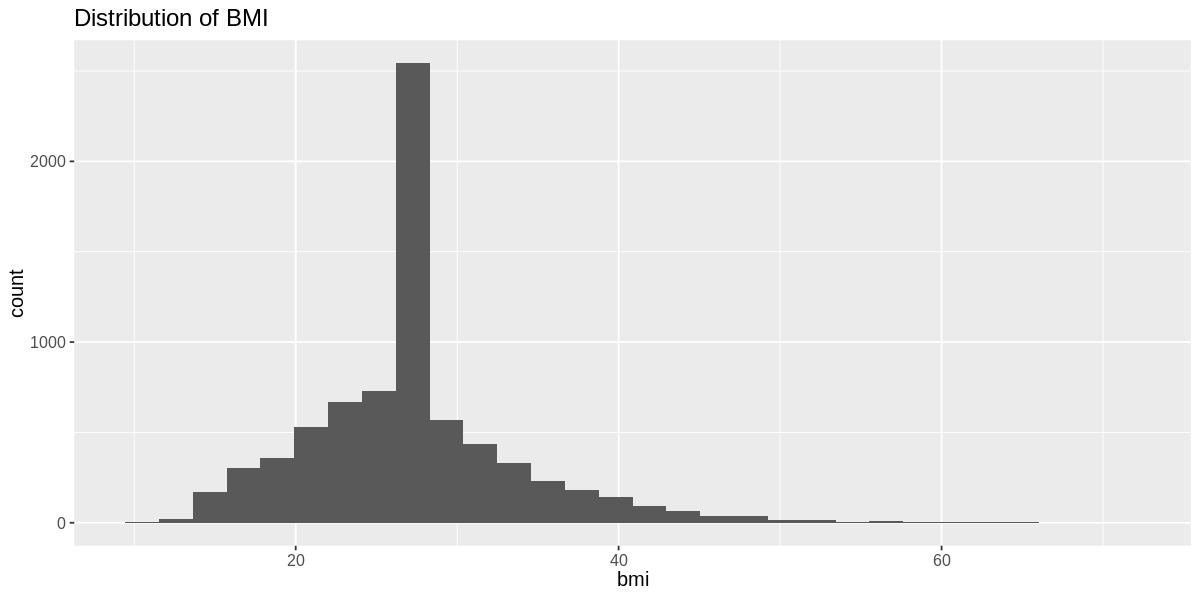

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


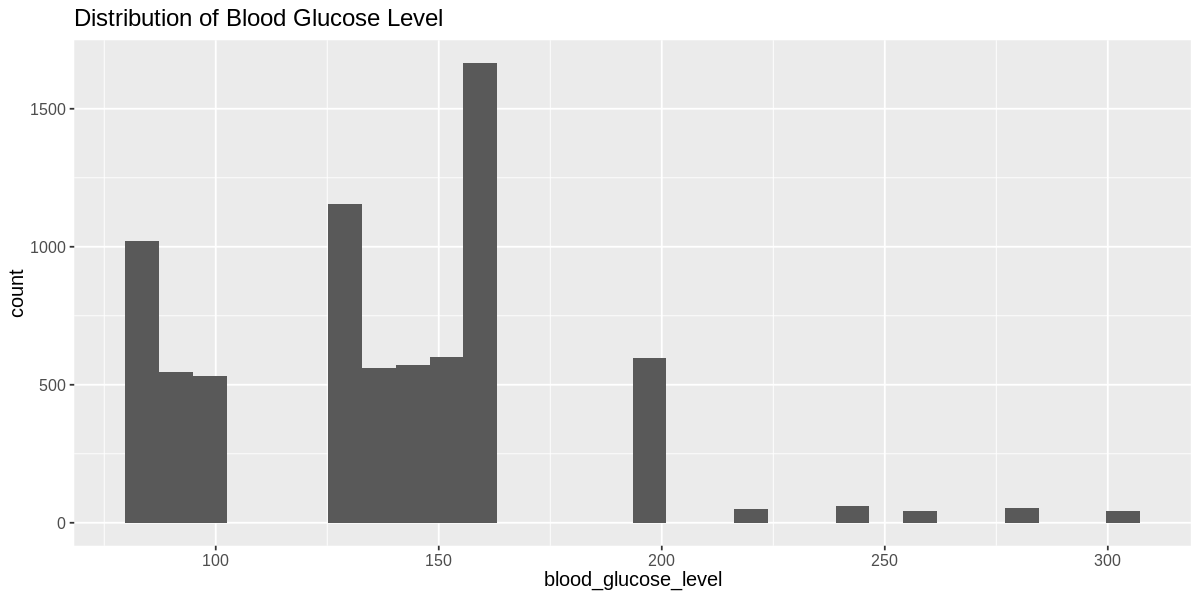

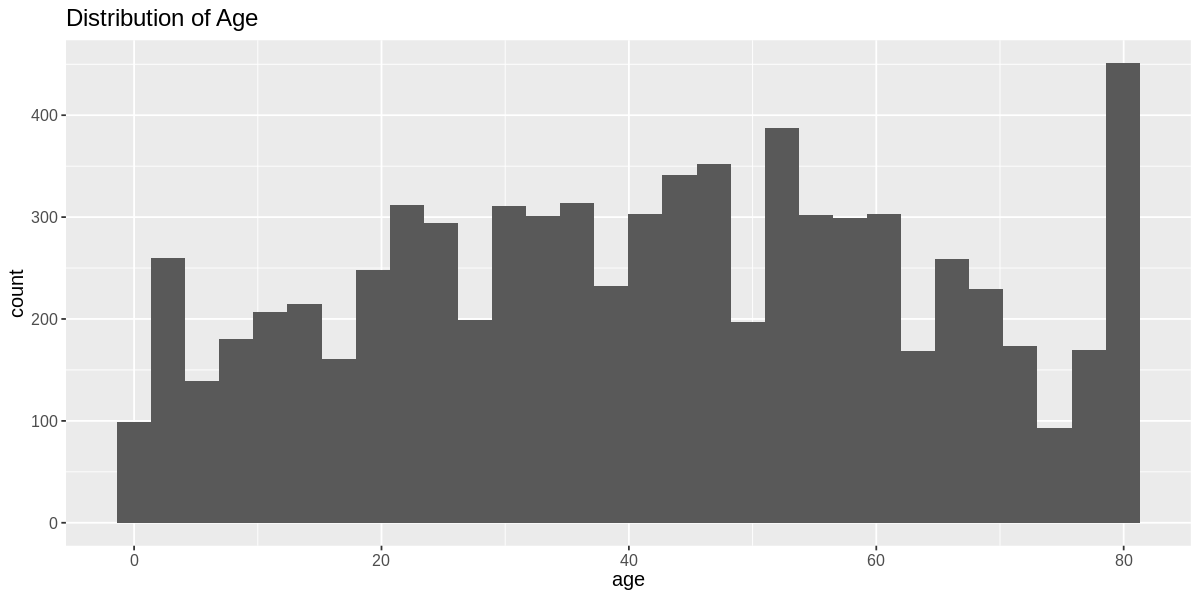

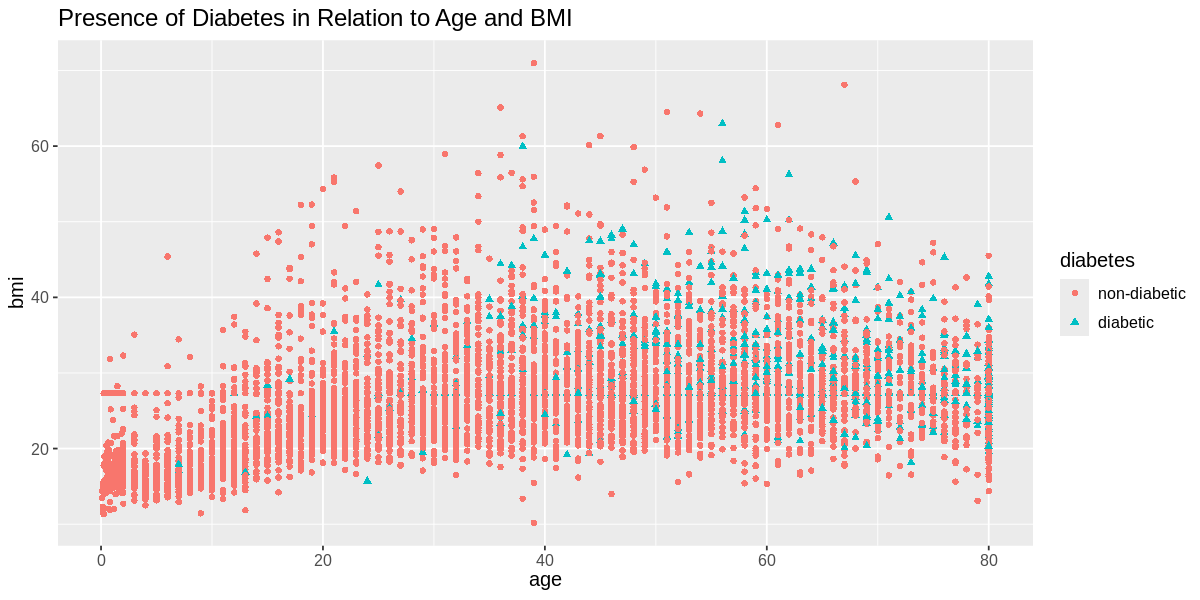

In [4]:
#making histograms and scatterplot
options(repr.plot.height = 5, repr.plot.width = 10)

bmi_dist <- ggplot(diabetes_train, aes(x = bmi)) + 
    geom_histogram() + 
    theme(text = element_text(size = 12)) + 
    ggtitle("Distribution of BMI") 

blood_glucose_dist <- ggplot(diabetes_train, aes(x = blood_glucose_level)) + 
    geom_histogram() + 
    theme(text = element_text(size = 12)) + 
    ggtitle("Distribution of Blood Glucose Level")

age_dist <- ggplot(diabetes_train, aes(x = age)) + 
    geom_histogram() + 
    theme(text = element_text(size = 12)) + 
    ggtitle("Distribution of Age")

age_bmi <- ggplot(diabetes_train, aes(x = age, y = bmi, color = diabetes, shape = diabetes)) + 
    geom_point() + 
    theme(text = element_text(size = 12)) + 
    ggtitle("Presence of Diabetes in Relation to Age and BMI")

bmi_dist
blood_glucose_dist
age_dist
age_bmi

**Graph explanation and its relevance to the analysis**

The histograms showing the distributions of the three predictor variables demonstrate that they are not normally distributed. Additionally, the scales are vastly different between different variables. This means that it will be necessary to scale and centre them in order to produce accurate predictions. 
The scatter plot showing presence of diabetes in relation to Age and BMI suggests that diabetes is more common in older people, but appears to show little to no relationship with BMI. This suggests that some of our variables may more effectively predict diabetes than others. The scatter plot also demonstrates that there are significantly more non-diabetic than diabetic data points, which means that the diabetic data points will need to be upscaled for the algorithm to produce accurate predictions. 


In this code, we first downsample the training data to balance the class distribution, ensuring no bias towards more frequently occurring classes. We then configure a K-nearest neighbors (KNN) model with a 'rectangular' weight function and use 5-fold cross-validation on the balanced dataset. This involves dividing the dataset into five parts, using each sequentially as a validation set while the others are used for training, which helps assess the model's performance across different data subsets. We test various k values, ranging from 1 to 100 in increments of 5, to find the one that achieves the highest validation accuracy, effectively selecting a k that optimally balances bias and variance. The optimal k is then determined by the value that yields the highest average accuracy across all folds, ensuring the model is accurately tuned for generalizable predictions.tions.

In [5]:
#cross validation to find the optimal k value
set.seed(1)
#downsampling the training set
downsample_recipe <- recipe(diabetes ~ bmi + age + blood_glucose_level, data = diabetes_train) |>
    step_downsample(diabetes, under_ratio = 1, skip = FALSE) |> 
    prep() 
downsampled_diabetes_train <- bake(downsample_recipe, diabetes_train) 

#making sure the downsampling works
prop <- downsampled_diabetes_train |> 
    group_by(diabetes) |> 
    summarize(n = n())
prop 

#finding optimal k value with downsampling 
diabetes_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

diabetes_recipe <- recipe(diabetes ~ bmi + age + blood_glucose_level, data = downsampled_diabetes_train) |>
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

diabetes_vfold <- vfold_cv(downsampled_diabetes_train, v = 5, strata = diabetes)
k_vals = tibble(neighbors = seq(from = 1, to = 100, by = 5))

cv_results <- workflow() |> 
    add_model(diabetes_tune) |> 
    add_recipe(diabetes_recipe) |> 
    tune_grid(resamples = diabetes_vfold, grid = k_vals) |> 
    collect_metrics() |> 
    filter(.metric == "accuracy") |> 
    select(neighbors, mean) 

best_k <- cv_results |> 
    arrange(desc(mean)) |> 
    head(1) |> 
    pull(neighbors) 
best_k

#finding optimal k value without downsampling 

diabetes_recipe_2 <- recipe(diabetes ~ bmi + age + blood_glucose_level, data = diabetes_train) |>
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

diabetes_vfold_2 <- vfold_cv(diabetes_train, v = 5, strata = diabetes)

cv_results_2 <- workflow() |> 
    add_model(diabetes_tune) |> 
    add_recipe(diabetes_recipe_2) |> 
    tune_grid(resamples = diabetes_vfold_2, grid = k_vals) |> 
    collect_metrics() |> 
    filter(.metric == "accuracy") |> 
    select(neighbors, mean) 

best_k_2 <- cv_results_2 |> 
    arrange(desc(mean)) |> 
    head(1) |> 
    pull(neighbors) 
best_k_2

diabetes,n
<fct>,<int>
non-diabetic,634
diabetic,634


[1] 36

[1] 11

After identifying the best k value that maximizes accuracy, we pug in this k value into our nearest_neighbor function to set up our KNN classifier. Using the previously specified configuration, we assemble our model within a workflow, combining both the model specifications and the data preprocessing recipe. The model is then trained on the downsampled training dataset.

Next, we evaluate the model's performance on the test dataset. Predictions are made for the diabetes_test dataset, and these predictions are combined with the actual test data to facilitate further analysis. We calculate key performance metrics, specifically focusing on accuracy, precision, and recall, to assess the effectiveness of our model. These metrics provide a comprehensive understanding of how well our model predicts diabetes cases.

Additionally, we generate a confusion matrix from the predictions. This matrix is crucial as it visually represents the accuracy of the model by showing the true positives, true negatives, false positives, and false negatives. This helps in further evaluating the model’s diagnostic ability in differentiating between diabetic and non-diabetic cases.

In [6]:
set.seed(1)
#classifier with downsampling
diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> 
    set_engine("kknn") |> 
    set_mode("classification") 
diabetes_classifier <- workflow() |> 
    add_recipe(diabetes_recipe) |> 
    add_model(diabetes_spec) |> 
    fit(data = downsampled_diabetes_train) 
predictions <- predict(diabetes_classifier, diabetes_test) |> 
    bind_cols(diabetes_test) 
prediction_metrics <- metrics(predictions, truth = diabetes, estimate = .pred_class) |> 
    filter(.metric == "accuracy") 
prediction_metrics
conf_mat <- conf_mat(predictions, truth = diabetes, estimate = .pred_class)
conf_mat
#classifier without downsampling
diabetes_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_2) |> 
    set_engine("kknn") |> 
    set_mode("classification") 
diabetes_classifier_2 <- workflow() |> 
    add_recipe(diabetes_recipe_2) |> 
    add_model(diabetes_spec_2) |> 
    fit(data = diabetes_train) 
predictions_2 <- predict(diabetes_classifier_2, diabetes_test) |> 
    bind_cols(diabetes_test) 
prediction_metrics_2 <- metrics(predictions_2, truth = diabetes, estimate = .pred_class) |> 
    filter(.metric == "accuracy") 
prediction_metrics_2
conf_mat_2 <- conf_mat(predictions_2, truth = diabetes, estimate = .pred_class)
conf_mat_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7532


              Truth
Prediction     non-diabetic diabetic
  non-diabetic         1676       39
  diabetic              578      207

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9336


              Truth
Prediction     non-diabetic diabetic
  non-diabetic         2250      162
  diabetic                4       84

<a id="predictor_explanation"></a>
**Predictor explanation**

The risk of developing diabetes increases with age due to changes in the human body such as altered metabolism and insulin sensitivity. Higher BMI is often linked with an increased risk of type 2 diabetes,
as excess body fat can affect insulin resistance. The blood glucose level is a direct indicator of diabetes. Elevated levels suggest problems with insulin use or production in the body.
The explanation for each predictor highlights their major role in determining whether an individual has diabetes, thereby justifying their selection for this research.

<a id="summary_table"></a>

**Summary trable explanation and why is it relevant to the analysis**

“class_distribution “ table displays the number of participants categorized as diabetics and non-diabetics in our dataset. This is crucial for ensuring that our dataset is not significantly biased toward one category (non-diabetics). An imbalanced dataset could result in a predictive model that  frequently classifies patients as non-diabetic, leading to poor performance on the minority class (diabetic). By understanding the data distribution, we can choose the appropriate metrics for our model, enhancing its accuracy in making predictions . The ”predictor_means” table presents the average values of BMI,age,and blood glucose level for the training data. These averages are important for understanding the central tendency of our numerical variables, which aids us to spot outliers and understand the overall data distribution. 

**Discussion**

**References**